In [1]:
from project_functions import *
sns.set(rc={'figure.figsize':(15,8)})

In [2]:
dataset1_train_feat = pd.read_csv('input_train.csv', index_col=0)
dataset2_train_tgt = pd.read_csv('label_train.csv', index_col=0).rename({'0':'target'}, axis=1)
dataset3_oos = pd.read_csv('input_test.csv', index_col=0)

# rename features
dataset1_train_feat.columns = [f'f{i}' for i in dataset1_train_feat.columns]
dataset3_oos.columns = dataset1_train_feat.columns

# df dataset contains labeled data
df = dataset2_train_tgt.join(dataset1_train_feat)

# set target labels as 0, 1
df['target'] = df['target'].mask(df['target']==-1, 0)

# Check if target is balanced (yes it is) and if there are missing values anywhere (no)
print('values count', df.target.value_counts())
print('missing values', df.isna().sum().sum() + dataset3_oos.isna().sum().sum())

# shuffle train set with explicit seed for reproducibility
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

# features list
features = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']

# perform train, validation, test splitting
train = df.iloc[:int(len(df)*0.6)].copy()
valid = df.iloc[int(len(df)*0.6):int(len(df)*0.8)].copy()
test = df.iloc[int(len(df)*0.8):].copy()

values count target
1    27000
0    27000
Name: count, dtype: int64
missing values 0


In [3]:
# main stats
train.describe()

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
count,32400.000000,32400.000000,32400.000000,32400.000000,32400.000000,32400.000000,32400.000000,32400.000000,32400.000000,32400.000000,32400.000000
mean,0.502160,-0.002684,0.004148,-0.011121,-0.016075,0.011589,0.006718,-0.021125,-0.012801,0.010887,-0.001562
std,0.500003,2.934131,1.836031,2.582872,9.273517,6.554182,2.286354,7.112323,3.119319,3.877522,5.682471
min,0.000000,-9.190080,-4.478100,-6.349113,-24.000956,-15.990667,-5.446004,-18.057349,-7.704268,-9.774194,-13.717451
25%,0.000000,-2.277035,-1.622865,-2.358421,-8.152798,-5.830008,-2.039118,-6.242573,-2.778318,-3.407558,-5.115652
50%,1.000000,0.011428,0.002792,-0.033149,-0.028696,-0.030085,0.013492,-0.042769,-0.060230,0.033894,-0.028619
75%,1.000000,2.278593,1.651562,2.291702,8.210719,5.941178,2.082777,6.213158,2.753379,3.456364,5.080656
max,1.000000,10.309414,4.476858,6.482681,23.570072,15.501622,5.920241,18.367373,7.706590,9.529262,12.843800


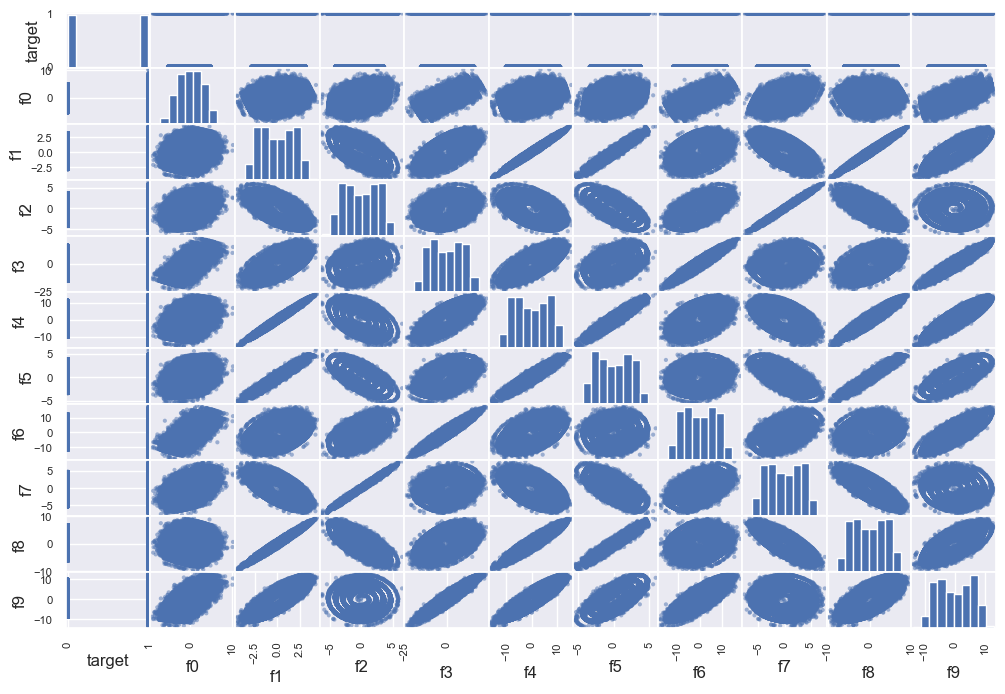

In [4]:
# visualize dataset
scatter_matrix(train, figsize=(12, 8))
plt.show()

<Axes: >

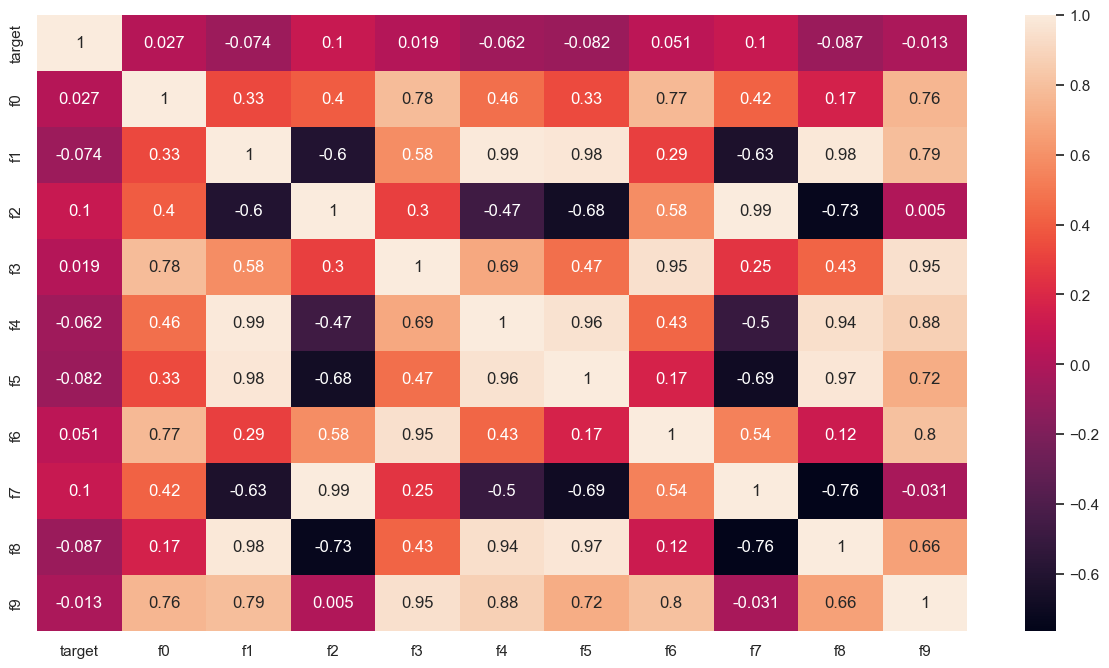

In [5]:
sns.heatmap(train.corr(method='spearman'), annot=True)

## Dimensionality Reduction

In [6]:
# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train[features])
X_valid_scaled = scaler.transform(valid[features])
X_test_scaled = scaler.transform(test[features])
X_oos_scaled = scaler.transform(dataset3_oos)

y_train = train['target']
y_valid = valid['target']
y_test = test['target']

# Fit Kernel PCA for dimensionality reduction
rbf_pca = KernelPCA(n_components = 3, kernel = 'rbf', gamma = 0.025, random_state=1)
X_train_kpca = rbf_pca.fit_transform(X_train_scaled)
X_valid_kpca = rbf_pca.transform(X_valid_scaled)
X_test_kpca = rbf_pca.transform(X_test_scaled)
X_oos_kpca = rbf_pca.transform(X_oos_scaled)

X_train_kpca = pd.DataFrame(X_train_kpca, columns = ['kpca1', 'kpca2', 'kpca3'], index=train.index)
X_valid_kpca = pd.DataFrame(X_valid_kpca, columns = ['kpca1', 'kpca2', 'kpca3'], index=valid.index)
X_test_kpca = pd.DataFrame(X_test_kpca, columns = ['kpca1', 'kpca2', 'kpca3'], index=test.index)
X_oos_kpca = pd.DataFrame(X_oos_kpca, columns = ['kpca1', 'kpca2', 'kpca3'], index=dataset3_oos.index)

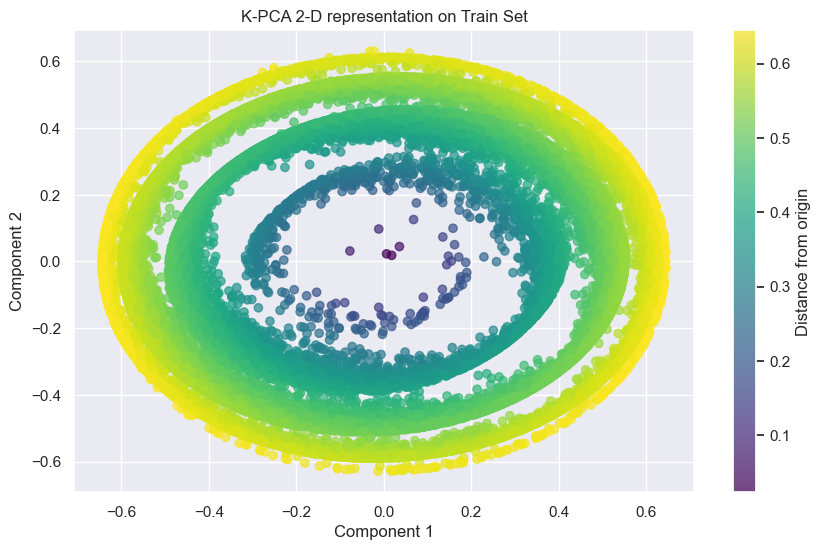

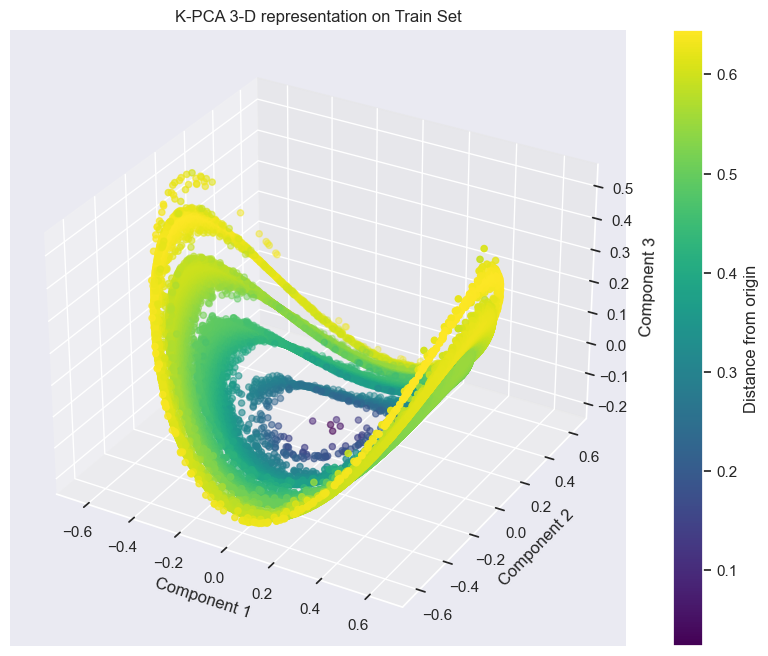

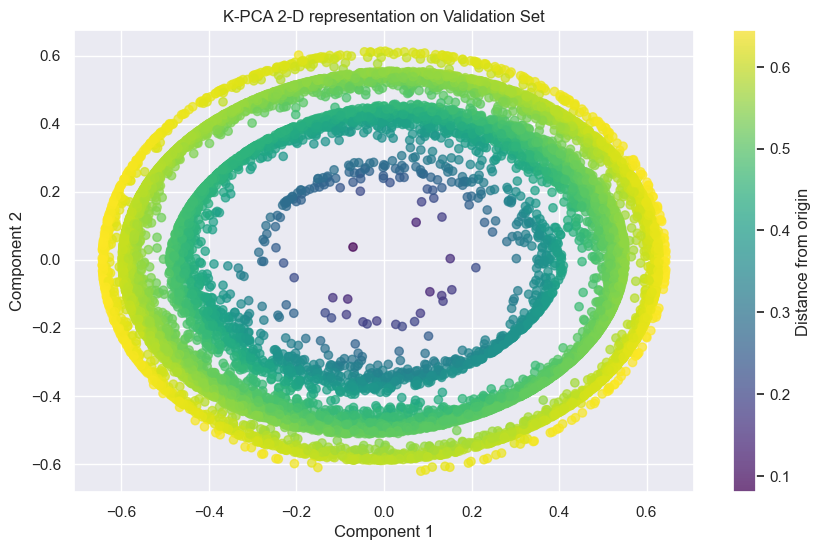

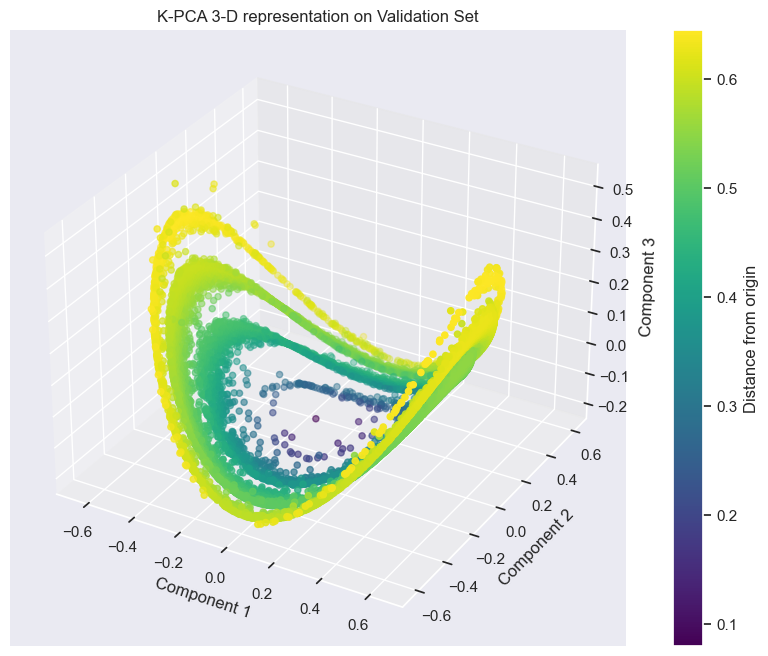

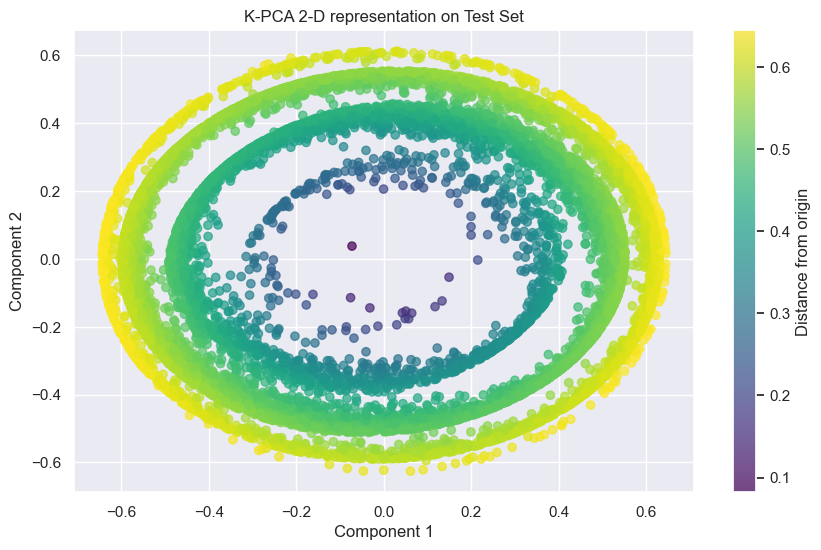

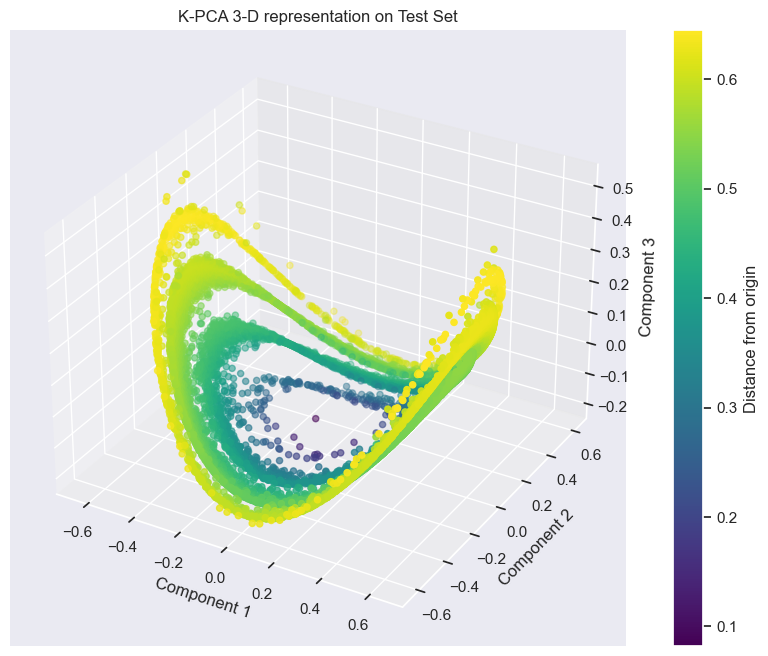

In [7]:
plot_2d(X_train_kpca['kpca1'], X_train_kpca['kpca2'], 'K-PCA 2-D representation on Train Set')
plot_3d(X_train_kpca['kpca1'], X_train_kpca['kpca2'], X_train_kpca['kpca3'], 'K-PCA 3-D representation on Train Set')

plot_2d(X_valid_kpca['kpca1'], X_valid_kpca['kpca2'], 'K-PCA 2-D representation on Validation Set')
plot_3d(X_valid_kpca['kpca1'], X_valid_kpca['kpca2'], X_valid_kpca['kpca3'], 'K-PCA 3-D representation on Validation Set')

plot_2d(X_test_kpca['kpca1'], X_test_kpca['kpca2'], 'K-PCA 2-D representation on Test Set')
plot_3d(X_test_kpca['kpca1'], X_test_kpca['kpca2'], X_test_kpca['kpca3'], 'K-PCA 3-D representation on Test Set')

## Classification model

In [8]:
train = train.join(X_train_kpca)
valid = valid.join(X_valid_kpca)
test = test.join(X_test_kpca)
dataset3_oos = dataset3_oos.join(X_oos_kpca)

features += list(X_train_kpca.columns)

X_train = train[features].values
X_valid = valid[features].values
X_test = test[features].values
X_oos = dataset3_oos.values

Python(4288) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 300/300 [14:30<00:00,  2.90s/it] 


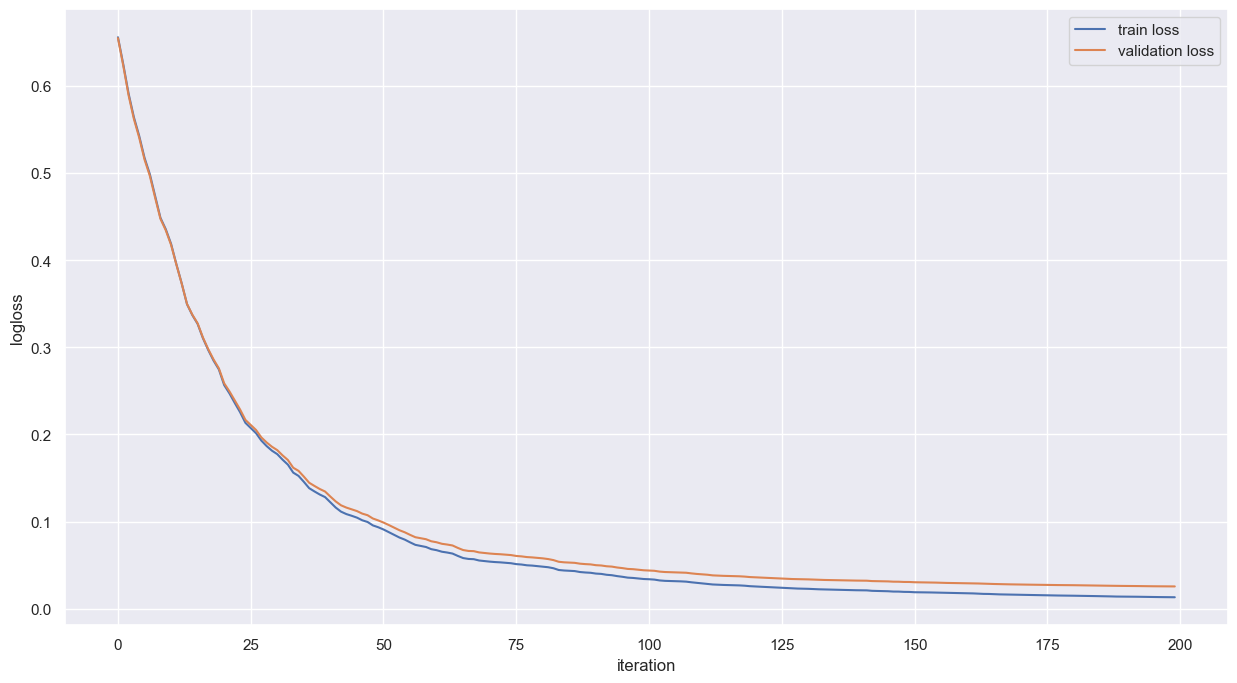

In [9]:
# grid search on model parameters
grid_search_params = [
            [100, 200, 300, 500, 1000], # n_estimators
            [0.001, 0.01, 0.1, 0.5, 0.8], # learning_rate
            [3, 6, 9, 12], # max_depth
            [0, 1, 2], # gamma
        ]

model_configs = []
for elem in itertools.product(*grid_search_params):
    model_configs.append(elem)

best_accuracy = 0

for param_gs in tqdm.tqdm(model_configs):
    # fit model on training data
    model = XGBClassifier(n_estimators=param_gs[0],
            learning_rate=param_gs[1],
            max_depth=param_gs[2],
            gamma=param_gs[3],
            eval_metric='logloss',
        )
    
    eval_set = [(X_train, y_train), (X_valid, y_valid)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    # make predictions for validation data
    y_pred_valid = model.predict(X_valid)

    # evaluate predictions
    accuracy = accuracy_score(y_valid, y_pred_valid)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = param_gs
        best_model = model
        best_mod_results = model.evals_result()

# plot train and validation loss for best model
plt.plot(best_mod_results['validation_0']['logloss'])
plt.plot(best_mod_results['validation_1']['logloss'])
plt.legend(['train loss', 'validation loss'])
plt.ylabel('logloss')
plt.xlabel('iteration')
plt.show()

In [10]:
print(f'Best Model parameters\n\nnum. estimators: {best_params[0]}\nlearning rate: {best_params[1]}\nmax depth: {best_params[2]}\ngamma: {best_params[3]}\n\n')
print(f'Best Model Accuracy on Validation set ({round(best_accuracy, 4)}), Test set ({round(accuracy_score(y_test, best_model.predict(X_test)), 4)})')

Best Model parameters

num. estimators: 200
learning rate: 0.1
max depth: 9
gamma: 0


Best Model Accuracy on Validation set (0.9919), Test set (0.9904)


In [12]:
# Best Model prediction on OOS dataset
oos_prediction = pd.DataFrame(best_model.predict(X_oos), columns=['y_predicted'])
oos_prediction = oos_prediction.mask(oos_prediction==0, -1)